In [1]:
import numpy as np
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap, ScalarMappable
import matplotlib.image as mpimg
from hamiltonian import *
from parameters import *
import qutip as qt

#old_settings = np.seterr(divide='ignore', invalid='ignore') # Necessary to suppress warnings for low T

In [2]:
# Find magnitude of B-field needed for qubit frequency at given B-field angle
i_defect = 0 # model SiV
H, _, _ = create_hamiltonian()

Ncases = 5
T = 4

alpha = 100
B = np.linspace(0, 50, 300)
theta = np.linspace(0, 90, Ncases)*np.pi/180
BH, thetaH, TH, _ = tensor_repeat(B, theta, T, np.zeros((4,4)))

BHx = BH*np.sin(thetaH)
BHz = BH*np.cos(thetaH)

f_target = 5 # [GHz] Target qubit frequency
BH = target_frequency_parameters(f_target, BH, 0, BHx, 0, BHz, qs[i_defect], Ls[i_defect], alpha, 0)

# Re-calculate eigenvalues
BH, _ = tensor_repeat(BH, np.zeros((4,4)))
thetaH = thetaH[0,:]
TH = TH[0,...]
BHx = BH*np.sin(thetaH)
BHz = BH*np.cos(thetaH)

Hgiv = H(BHx, 0, BHz, qs[i_defect], Ls[i_defect], alpha, 0)
E, U = np.linalg.eigh(Hgiv)
E_Q, E_orb, lambda_eff = diagonalised_hamiltonian_parameters( E )


In [3]:
# Find theoretical coherence times

gamma_T1, gamma_T2, gammaOrb = calculate_gamma(E, U, chi_err[0,i_defect], TH)

T2_corr = T_eff_approx( 0.5*gamma_T1+10, 0.5*gammaOrb, lambda_eff*1e9 )

In [4]:
# Calculate four-level system Lindbladian operators
gamma = calculate_gamma_thermalised( E, U, chi_err[0,i_defect], TH[...,0,0] )

L0 = np.zeros( (Ncases, 4, 4, 4, 4) )

for i in range(4):
    for j in range(4):
        L0[:,i,j,i,j] = np.sqrt(gamma[:,i,j]/1e9) # Convert to ns

Lcorr = np.array(L0)

# Degeneracy corrections
Lcorr[:,0,1,:,:] = ( L0[:,0,1,:,:] + L0[:,2,3,:,:] )/np.sqrt(2)
Lcorr[:,1,0,:,:] = ( L0[:,1,0,:,:] + L0[:,3,2,:,:] )/np.sqrt(2)
Lcorr[:,2,3,:,:] = ( L0[:,0,1,:,:] + L0[:,2,3,:,:] )/np.sqrt(2)
Lcorr[:,3,2,:,:] = ( L0[:,1,0,:,:] + L0[:,3,2,:,:] )/np.sqrt(2)

Lcorr[:,0,2,:,:] = ( L0[:,0,2,:,:] + L0[:,1,3,:,:] )/np.sqrt(2)
Lcorr[:,2,0,:,:] = ( L0[:,2,0,:,:] + L0[:,3,1,:,:] )/np.sqrt(2)
Lcorr[:,1,3,:,:] = ( L0[:,0,2,:,:] + L0[:,1,3,:,:] )/np.sqrt(2)
Lcorr[:,3,1,:,:] = ( L0[:,2,0,:,:] + L0[:,3,1,:,:] )/np.sqrt(2)

L0 = [[ qt.Qobj( L0[i,j,k,...] ) for j in range(L0.shape[1]) for k in range(L0.shape[2]) if j != k ] for i in range(L0.shape[0])]
Lcorr = [[ qt.Qobj( Lcorr[i,j,k,...] ) for j in range(Lcorr.shape[1]) for k in range(Lcorr.shape[2]) if j != k ] for i in range(Lcorr.shape[0])]

In [5]:
qubit_0 = qt.basis(4, 0)
qubit_1 = qt.basis(4, 1)

sigmaQx = qt.tensor( qt.identity(2), qt.sigmax())
sigmaQy = qt.tensor( qt.identity(2), qt.sigmay())
sigmaQz = qt.tensor( qt.identity(2), qt.sigmaz())

sigmaOrbx = qt.tensor( qt.sigmax(), qt.identity(2))
sigmaOrby = qt.tensor( qt.sigmay(), qt.identity(2))
sigmaOrbz = qt.tensor( qt.sigmaz(), qt.identity(2))

t = np.arange(0, 1000 + 1/(5*E_orb[-1]), 1/(5*E_orb[-1])) # [ns]

initial_state = (qubit_0 + qubit_1)/np.sqrt(2)

result = []
result_corr = []

expectation_ops = [sigmaQx, sigmaQy, sigmaOrbz ]

for i in range(Ncases):
    Hsolve = qt.Qobj( 2*np.pi*np.diag(E[i,:]) ) # Convert to radians/ns

    # Evolve with uncorrected decoherence
    result.append( qt.mesolve(Hsolve, initial_state * initial_state.dag(), t, L0[i], expectation_ops ) )

    # Evolve with degeneracy correction
    result_corr.append( qt.mesolve(Hsolve, initial_state * initial_state.dag(), t, Lcorr[i], expectation_ops ) )

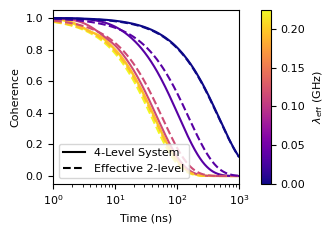

In [8]:
plt.rcParams.update({'font.size': 8})
fig = plt.figure(figsize=(3.38583, 0.7*3.38583))
gs = plt.GridSpec(ncols=2, nrows=1, width_ratios=[.95,.05], hspace=0.01)

# Plot coherence time
plt.subplot(gs[0,0])
cm = get_cmap('plasma')

# Corrected coherence times
[plt.semilogx( t, np.sqrt(result_corr[i].expect[0]**2 + result_corr[i].expect[1]**2), color=cm(lambda_eff[i]/np.max(lambda_eff))) for i in range(Ncases) ]

# Approximate coherence 
[plt.plot( t, np.exp(-t/(T2_corr[i]*1e9)), '--', color=cm(lambda_eff[i]/np.max(lambda_eff) ) ) for i in range(Ncases) ]

plt.plot( np.nan, np.nan, 'k', label="4-Level System")
plt.plot( np.nan, np.nan, 'k--', label="Effective 2-level")
plt.legend(loc="lower left")

plt.xlim( 1e0, 1e3)
plt.ylabel("Coherence")
plt.xlabel("Time (ns)")

ax = plt.subplot(gs[0,1])
sm = plt.cm.ScalarMappable(cmap=cm, norm=plt.Normalize(vmin=min(lambda_eff), vmax=max(lambda_eff)) )
cbar = plt.colorbar(sm, cax=ax, label=r'$\lambda_\mathrm{eff}$ (GHz)')


gs.tight_layout(fig)

plt.savefig("Fig2_Coherence.png", dpi=600)

plt.show()